In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from scipy.stats import invwishart, percentileofscore
import time

In [ ]:
df = pd.read_excel("datos.xlsx", sheet_name="Hoja2", usecols="B:J", skiprows=1, nrows=252)
columnas = ["IPC", "GDP", "Tasa_Ref", "ToT", "Deprec_Nom_12M", "IPC_sae", "TPU_g", "Cobre", "Petroleo_WTI"]
df.columns = columnas

date = pd.date_range(start="2004-01-01", periods=252, freq="M")
df.index = date

C:\Users\jhers\AppData\Local\Temp\ipykernel_33796\4165380151.py:5: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



C:\Users\jhers\AppData\Local\Temp\ipykernel_33796\1252531839.py:10: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



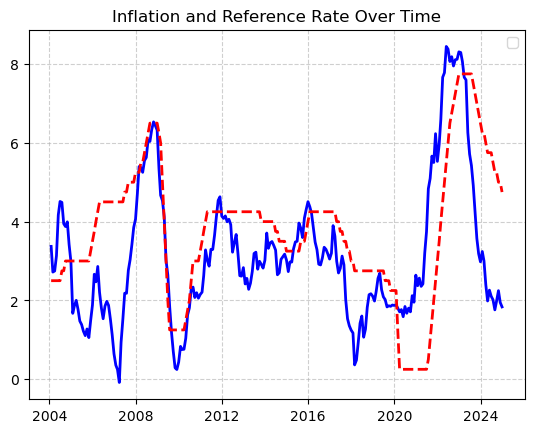

In [ ]:
# Rate and Inflation
data = df[["Tasa_Ref", "IPC"]].copy()
N = data.shape[1]
L = 3
Y = data.values

plt.plot(df.index, df["IPC"], color="blue", linewidth=2)
plt.plot(df.index, df["Tasa_Ref"], color="red", linestyle="dashed", linewidth=2)
plt.title("Inflation and Reference Rate Over Time")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [290]:
N = data.shape[1]
L = 2  # Number of lags in the VAR
Y = data.values

# Create lagged variables
X = np.column_stack((np.ones((Y.shape[0], 1)), np.roll(Y, 1, axis=0), np.roll(Y, 2, axis=0)))
Y = Y[2:]
X = X[2:]
T = X.shape[0]

In [291]:
# Compute standard deviation of each series' residual via an OLS regression
# First variable
y = Y[:, 0]
x = X[:, [0, 1]]
b0 = np.linalg.solve(x.T @ x, x.T @ y)
s1 = np.sqrt(((y - x @ b0) @ (y - x @ b0)) / (y.shape[0] - 2))

In [292]:
# Second variable
y = Y[:, 1]
x = X[:, [0, 2]]
b0 = np.linalg.inv(x.T @ x) @ x.T @ y
#b0 = np.linalg.solve(x.T @ x, x.T @ y)
s2 = np.sqrt(((y - x @ b0) @ (y - x @ b0)) / (y.shape[0] - 2))
s1,s2

(0.23522631939820557, 0.39521901646378993)

In [293]:
# Specify parameters of the Minnesota prior
lamda1 = 1  # Controls the prior on own lags
lamda2 = 1
lamda3 = 1
lamda4 = 1

# Specify the prior mean of the coefficients of the two equations of the VAR
B01 = np.array([0, 1, 0, 0, 0])
B02 = np.array([0, 0, 1, 0, 0])

B0 = np.concatenate((B01, B02))

In [294]:
# Specify the prior variance of vec(B)
H = np.zeros((10, 10))
# For equation 1 of the VAR
H[0, 0] = (s1 * lamda4) ** 2  # Constant
H[1, 1] = (lamda1) ** 2  # Own lag
H[2, 2] = ((s1 * lamda1 * lamda2) / s2) ** 2  # Lag of the other variable
H[3, 3] = (lamda1 / (2 ** lamda3)) ** 2  # Own second lag
H[4, 4] = ((s1 * lamda1 * lamda2) / (s2 * (2 ** lamda3))) ** 2  # Lag of the other variable
# For equation 2 of the VAR
H[5, 5] = (s2 * lamda4) ** 2  # Constant
H[6, 6] = ((s2 * lamda1 * lamda2) / s1) ** 2  # Lag of the other variable
H[7, 7] = (lamda1) ** 2  # Own lag
H[8, 8] = ((s2 * lamda1 * lamda2) / (s1 * (2 ** lamda3))) ** 2  # Lag of the other variable
H[9, 9] = (lamda1 / (2 ** lamda3)) ** 2  # Own second lag

In [295]:
def vec(y):
    x = np.array([]) 
    
    for i in range(1,y.shape[1]):
        x = np.vstack([x, y[:, i-1]])  
    
    return x


In [296]:
# Prior scale matrix for sigma, the VAR covariance
S = np.eye(N)
# Prior degrees of freedom
alpha = N + 1

# Starting values for the Gibbs sampling algorithm
Sigma = np.eye(N)
beta_ols = (np.linalg.inv(X.T@X))@(X.T@Y)
beta_ols = beta_ols.T.flatten()
beta_ols

array([ 0.04099203,  1.65261403,  0.07748488, -0.67473917, -0.06323721,
        0.18668708,  0.42508619,  1.20501229, -0.44614166, -0.24076877])

In [297]:
Reps = 10000
burn = 5000

In [298]:
def IWPQ(v, ixpx):
    k = ixpx.shape[0]
    z = np.zeros((v, k))
    mu = np.zeros((k, 1))

    for i in range(1,v):
        chol_ixpx = cholesky(ixpx,lower=False)#,lower=False)  #, lower=True)
        z[i, :] = (chol_ixpx.T @ np.random.randn(k, 1)).T

    out = np.linalg.inv(z.T @ z)
    return out

In [299]:
t = 0
start = time.time()

i=1
for j in range(1, Reps + 1):

    # Step 1: Draw the VAR coefficients
    M1 = np.linalg.inv(H) + np.kron(np.linalg.inv(Sigma), X.T @ X)
    M2 = np.linalg.inv(H) @ B0 + np.kron(np.linalg.inv(Sigma), X.T @ X) @ beta_ols
    M = np.linalg.solve(M1, M2)
    V = np.linalg.inv(M1)

    beta = M + np.random.randn(N * (N * L + 1)) @ cholesky(V, lower=False)


    # Step 2: Draw Sigma from the Inverted Wishart distribution
    e = Y - X @ beta.reshape(N,(N * L + 1)).T

    scale = e.T @ e + S
    Sigma = IWPQ(T + alpha, np.linalg.inv(scale))
    
    
    if j > burn:
        
        # Forecast Rate and inflation for 2 years
        yhat = np.zeros((26, 2))
        yhat[0:2, :] = Y[-2:, :]

        for i in range(2, 26):
            lag_val = np.concatenate([np.array([1]), yhat[i - 1, :], yhat[i - 2, :]])
            yhat[i, :] = lag_val@ (beta.reshape(N,N * L + 1)).T + np.random.randn(1, N) @ np.linalg.cholesky(Sigma)

        if j == burn + 1:
            out1 = np.hstack((Y[:, 0], yhat[2:, 0]))
            out2 = np.hstack((Y[:, 1], yhat[2:, 1]))
        else:
            out1 = np.c_[out1,np.hstack((Y[:, 0], yhat[2:, 0]))]
            out2 = np.c_[out2,np.hstack((Y[:, 1], yhat[2:, 1]))]    
    
        
    if (j + 1) % 1000 == 0:
        end = time.time()
        elapsed = end - start
        t += elapsed
        print(f"Iteración {j + 1}, tiempo acumulado: {t} s")
    #start_time= time.time()


Iteración 1000, tiempo acumulado: 3.6249706745147705 s
Iteración 2000, tiempo acumulado: 10.82080626487732 s
Iteración 3000, tiempo acumulado: 21.61961817741394 s
Iteración 4000, tiempo acumulado: 36.07474231719971 s
Iteración 5000, tiempo acumulado: 54.494425535202026 s
Iteración 6000, tiempo acumulado: 78.27170729637146 s
Iteración 7000, tiempo acumulado: 109.34703230857849 s
Iteración 8000, tiempo acumulado: 148.75958275794983 s
Iteración 9000, tiempo acumulado: 197.22767543792725 s
Iteración 10000, tiempo acumulado: 256.78902220726013 s


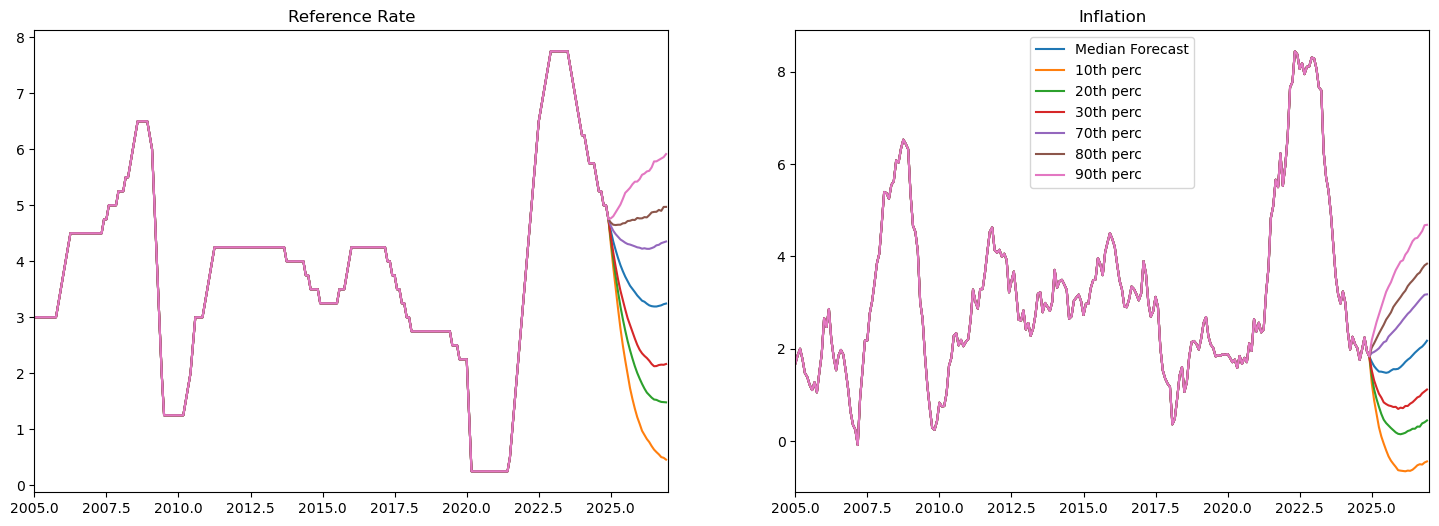

In [300]:
fig = plt.figure(figsize=(18, 6))

TT = np.arange(2004 + 2/12, 2026+ 12/12, 1/12)


plt.subplot(1, 2, 1)
percentiles = np.percentile(out1, [50, 10, 20, 30, 70, 80, 90], axis=1)
plt.plot(TT, percentiles.T)
plt.xlim([2005, 2027])
plt.title('Reference Rate')

plt.subplot(1, 2, 2)
percentiles = np.percentile(out2, [50, 10, 20, 30, 70, 80, 90], axis=1)
plt.plot(TT, percentiles.T)
plt.xlim([2005, 2027])
plt.legend(['Median Forecast', '10th perc', '20th perc', '30th perc',
            '70th perc', '80th perc', '90th perc'])
plt.title('Inflation')

plt.show()

fig.savefig('forecast_rate_and_inflation.png', dpi=fig.dpi)

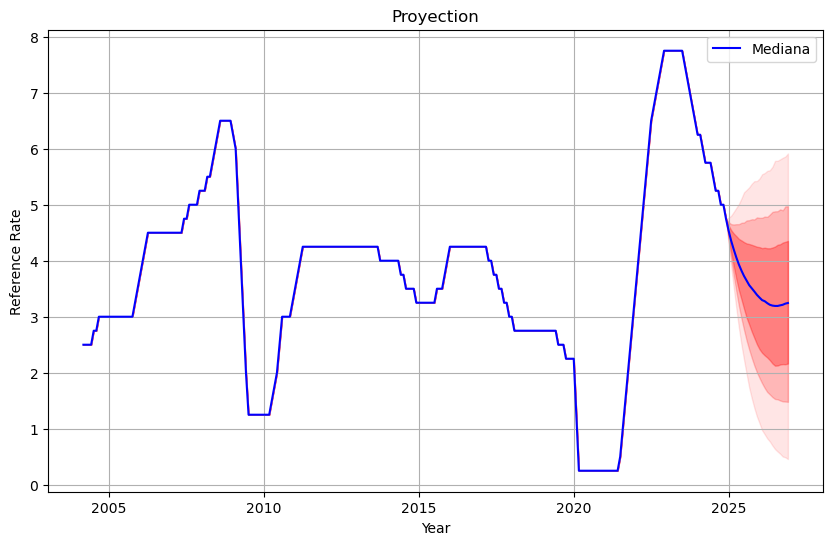

In [301]:
percentiles = np.percentile(out1.T, [10, 20, 30, 50, 70, 80, 90], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

for i, alpha in enumerate([0.1, 0.2, 0.3]):
    ax.fill_between(TT, percentiles[i], percentiles[6-i], color='red', alpha=alpha)

ax.plot(TT, percentiles[3], color='blue', label='Mediana')

# ax.set_xlim([2010, 2026.75])
ax.set_title('Proyection')
ax.set_xlabel('Year')
ax.set_ylabel('Reference Rate')
ax.legend()
ax.grid(True)

plt.show()

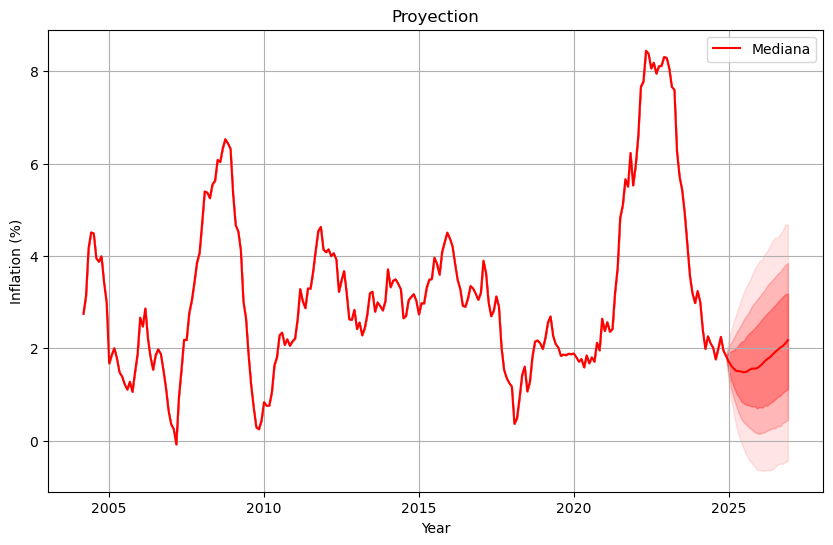

In [302]:
percentiles = np.percentile(out2.T, [10, 20, 30, 50, 70, 80, 90], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

# bandas de confianza como mapas de calor
for i, alpha in enumerate([0.1, 0.2, 0.3]):
    ax.fill_between(TT, percentiles[i], percentiles[6-i], color='red', alpha=alpha)

ax.plot(TT, percentiles[3], color='red', label='Mediana')

# ax.set_xlim([2010, 2026.75])
ax.set_title('Proyection')
ax.set_xlabel('Year')
ax.set_ylabel('Inflation (%)')
ax.legend()
ax.grid(True)

plt.show()

In [304]:
percentiles = np.percentile(out2.T, [10, 20, 30, 50, 70, 80, 90], axis=0)

fig = go.Figure()

colors = ["rgba(255, 0, 0, 0.1)", "rgba(255, 0, 0, 0.2)", "rgba(255, 0, 0, 0.3)"]
for i in range(3):
    fig.add_trace(go.Scatter(
        x=TT, y=percentiles[6 - i], mode="lines", line=dict(width=0),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=TT, y=percentiles[i], mode="lines", fill="tonexty",
        fillcolor=colors[i], line=dict(width=0), showlegend=False
    ))


fig.add_trace(go.Scatter(
    x=TT, y=percentiles[3], mode="lines",
    line=dict(color="red", width=2), name="Median"
))


fig.update_layout(
    title="Inflation",
    xaxis_title=None,
    yaxis_title="(%)",
    template="plotly_white",
    hovermode="x",
    xaxis=dict(range=[2010, 2027]),
    yaxis=dict(gridcolor="lightgray"),
    width=1000,  
    height=600,  
)


fig.show()
